In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
from pprint import pprint
import seaborn as sns
sns.set(style="whitegrid")

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 使用pandas读取csv文件并划分数据

In [2]:
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())  # .head()默认取前5条数据
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [3]:
y_train = train_df.pop("survived")
y_eval = eval_df.pop("survived")

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

## 2. 使用pandas了解数据信息

In [4]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


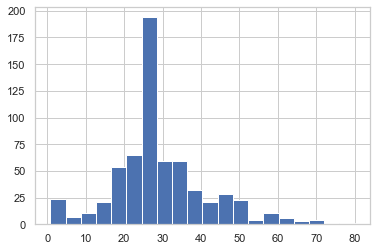

In [6]:
train_df.age.hist(bins=20)

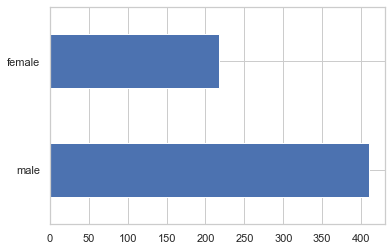

In [7]:
train_df.sex.value_counts().plot(kind="barh")

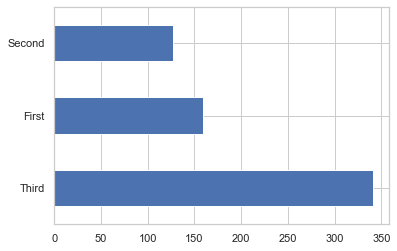

In [8]:
train_df["class"].value_counts().plot(kind="barh")

sex
female    0.778802
male      0.180488
Name: survived, dtype: float64


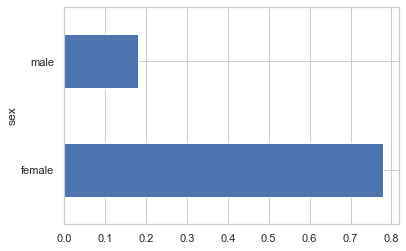

In [9]:
print(pd.concat([train_df, y_train], axis=1).groupby("sex").survived.mean())
pd.concat([train_df, y_train],                                                            axis=1).groupby("sex").survived.mean().plot(kind="barh")

## 3. 使用tf.feature_column处理特征

In [10]:
# tf.feature_column 定义的是处理各列连续和离散数据的规则
categorical_columns = ["sex", "n_siblings_spouses", "parch", "class", "deck",                        "embark_town", "alone"]
numeric_columns = ["age", "fare"]

feature_columns = []
# 离散特征处理
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        # 进行 one-hot 编码
        tf.feature_column.indicator_column(      
            # 生成 feature_column
            tf.feature_column.categorical_column_with_vocabulary_list(                          categorical_column, vocab)))

# 连续特征处理
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [11]:
def make_dataset(data_df, label_df, epochs=10, shuffle=True, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [12]:
train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [13]:
for x, y in train_dataset.take(1):
    print(x)
    print("-------------")
    print(y)

{'sex': <tf.Tensor: id=38, shape=(5,), dtype=string, numpy=array([b'male', b'male', b'female', b'male', b'female'], dtype=object)>, 'age': <tf.Tensor: id=30, shape=(5,), dtype=float64, numpy=array([ 7.,  1., 23., 28., 24.])>, 'n_siblings_spouses': <tf.Tensor: id=36, shape=(5,), dtype=int32, numpy=array([4, 4, 0, 0, 0])>, 'parch': <tf.Tensor: id=37, shape=(5,), dtype=int32, numpy=array([1, 1, 0, 0, 0])>, 'fare': <tf.Tensor: id=35, shape=(5,), dtype=float64, numpy=array([39.6875, 39.6875, 13.7917,  7.25  , 69.3   ])>, 'class': <tf.Tensor: id=32, shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'Second', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: id=33, shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'D', b'unknown', b'B'], dtype=object)>, 'embark_town': <tf.Tensor: id=34, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Cherbourg', b'Southampton',
       b'Cherbourg'], dtype=object)>, 'alone': <tf.Tensor: id=31, shape=(5,)

In [14]:
# keras.layers.DenseFeatures()将feature_columns里面的规则应用到数据集
for x, y in train_dataset.take(1):
#     单个特征处理举例
#     eg.
#     age_column = feature_columns[7]
#     gender_column = feature_columns[0]
#     print(keras.layers.DenseFeatures(age_column)(x).numpy())
#     print(keras.layers.DenseFeatures(gender_column)(x).numpy())

    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[28.      1.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  16.1     1.      0.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.     

In [15]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

## 4. 数据训练

### 4.1 使用model.fit训练数据

In [22]:
train_dataset = make_dataset(train_df, y_train, epochs=100, batch_size=32)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, batch_size=24)

history = model.fit(train_dataset,
                    validation_data=eval_dataset,
                    steps_per_epoch=19,   # steps_per_epoch <= 
                             #  num_examples(train_data) // batch_size(train)
                    validation_steps=10,    # validation_steps <= 
              # num_examples(valid_data) * epochs(valid) // batch_size(valid)
                    epochs=100)

Train for 19 steps, validate for 10 steps
Epoch 1/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4300 - accuracy: 0.8092 - val_loss: 0.4888 - val_accuracy: 0.7667
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4307 - accuracy: 0.8109 - val_loss: 0.4808 - val_accuracy: 0.7667
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4437 - accuracy: 0.8109 - val_loss: 0.6151 - val_accuracy: 0.6667
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4194 - accuracy: 0.8207 - val_loss: 0.4631 - val_accuracy: 0.7667
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4619 - accuracy: 0.7862 - val_loss: 0.5034 - val_accuracy: 0.7708
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4068 - accuracy: 0.8273 - val_loss: 0.5011 - val_accuracy: 0.7500
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4391 - accuracy: 0.8059 - val_loss: 0

### 4.2 使用estimator训练数据

model -> estimator -> train

In [17]:
estimator = keras.estimator.model_to_estimator(model)
estimator.train(input_fn=lambda : make_dataset(train_df, y_train, epochs=100))
# 参数input_fn的要求：
# 1. 是一个无参数的函数
# 2. 返回值形式如示： a. (features, labels)
#                    b. dataset -> (features, labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\NEO\\AppData\\Local\\Temp\\tmp0sn3arwu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C9946EE388>, '_task_type': 'worker', '_task_id': 0, '_global_

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.